## Data Exploration

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cuda


In [2]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE

In [3]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /home/shawnzhang/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [4]:
import os
os.listdir('./EMOVO/f1')

['tri-f1-b1.wav',
 'pau-f1-b1.wav',
 'gio-f1-n2.wav',
 'dis-f1-b2.wav',
 'gio-f1-l4.wav',
 'sor-f1-n4.wav',
 'rab-f1-l3.wav',
 'neu-f1-n2.wav',
 'rab-f1-d1.wav',
 'tri-f1-l2.wav',
 'tri-f1-d1.wav',
 'neu-f1-n3.wav',
 'tri-f1-l3.wav',
 'sor-f1-d2.wav',
 'neu-f1-l3.wav',
 'gio-f1-n1.wav',
 'sor-f1-b2.wav',
 'neu-f1-n4.wav',
 'tri-f1-l1.wav',
 'neu-f1-b1.wav',
 'gio-f1-n5.wav',
 'dis-f1-d2.wav',
 'sor-f1-b3.wav',
 'rab-f1-l2.wav',
 'dis-f1-n5.wav',
 'pau-f1-n1.wav',
 'tri-f1-n1.wav',
 'gio-f1-b1.wav',
 'tri-f1-n2.wav',
 'rab-f1-b3.wav',
 'tri-f1-b3.wav',
 'dis-f1-l1.wav',
 'pau-f1-l3.wav',
 'sor-f1-l1.wav',
 'sor-f1-l2.wav',
 'tri-f1-n3.wav',
 'rab-f1-b2.wav',
 'gio-f1-l3.wav',
 'rab-f1-l4.wav',
 'tri-f1-b2.wav',
 'sor-f1-d1.wav',
 'sor-f1-b1.wav',
 'sor-f1-l4.wav',
 'dis-f1-l4.wav',
 'gio-f1-d1.wav',
 'neu-f1-n1.wav',
 'sor-f1-n2.wav',
 'neu-f1-d2.wav',
 'dis-f1-l2.wav',
 'neu-f1-l1.wav',
 'pau-f1-n3.wav',
 'pau-f1-n2.wav',
 'pau-f1-l2.wav',
 'sor-f1-n5.wav',
 'rab-f1-n2.wav',
 'tri-f1-n

In [5]:
sample_file = './EMOVO/f1/dis-f1-n3.wav'
sample_wave, sr = torchaudio.load(sample_file)

In [6]:
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

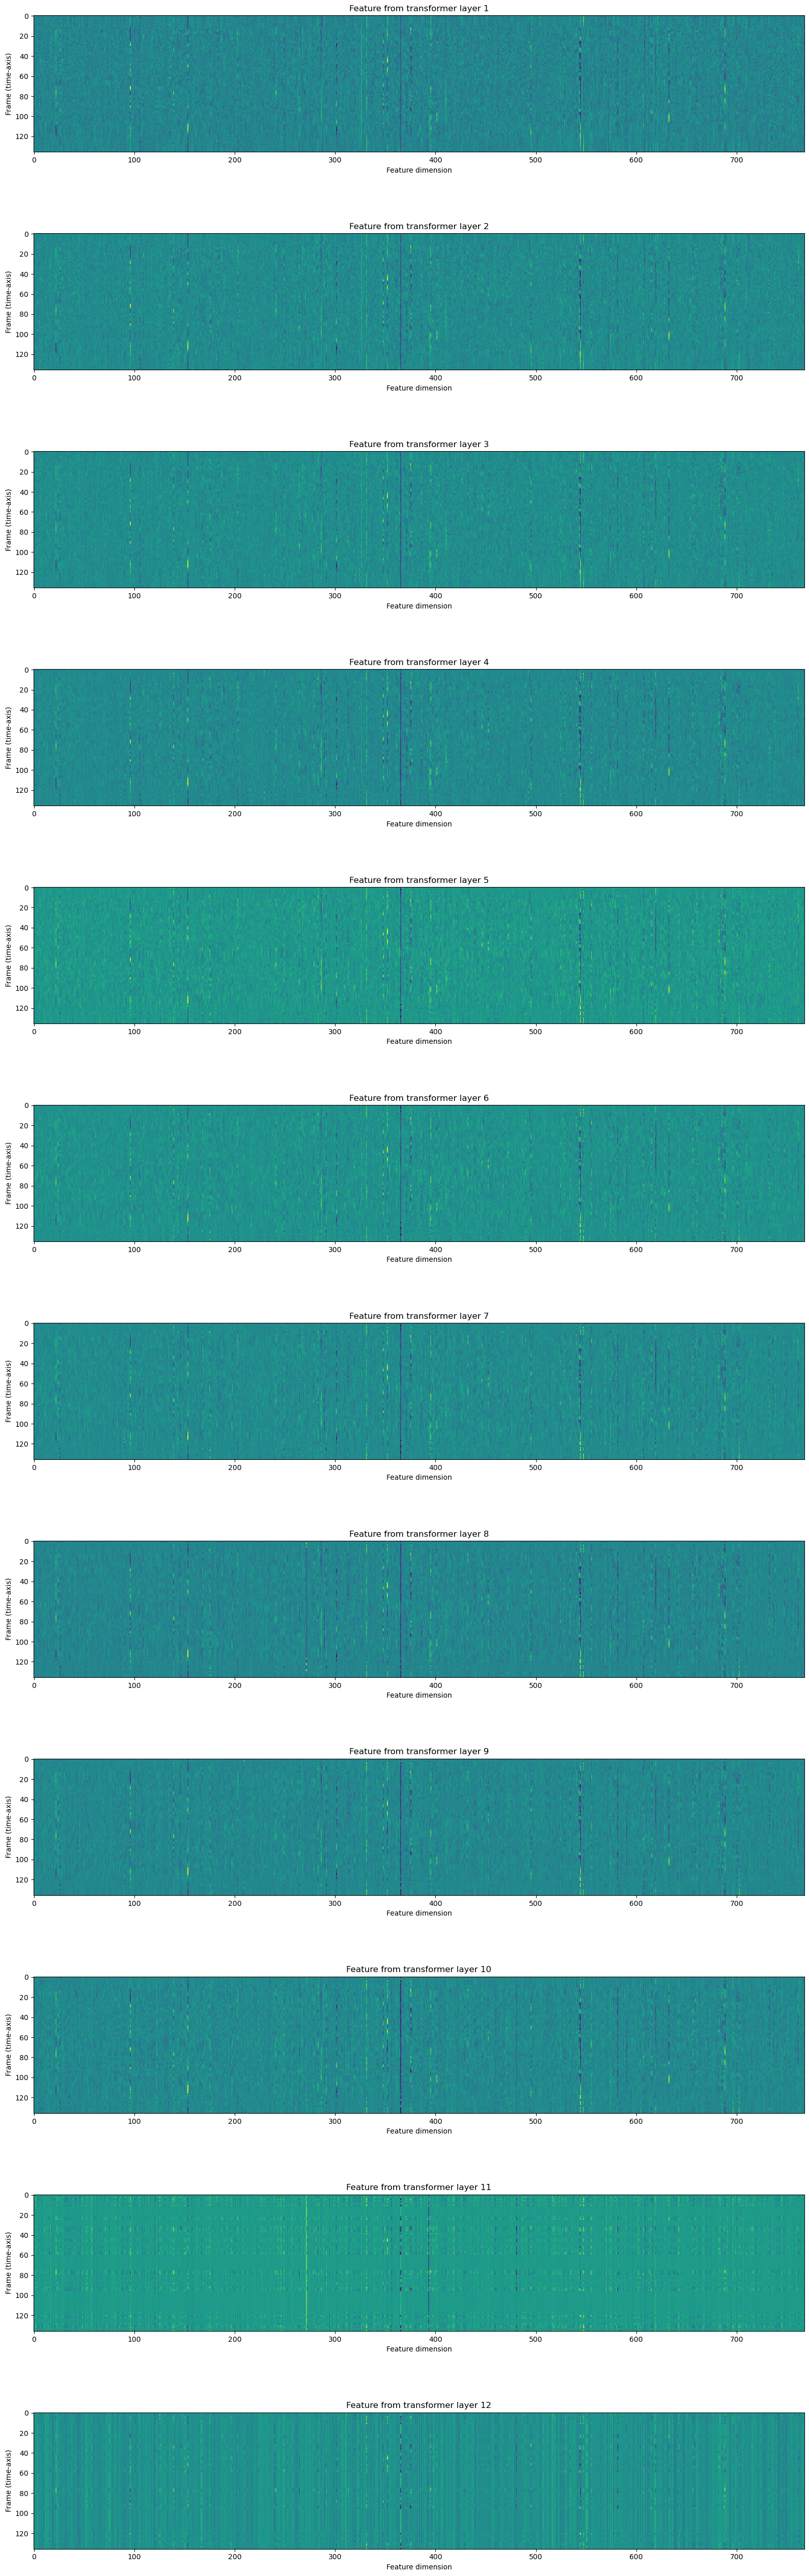

In [8]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [9]:
features[0].shape

torch.Size([2, 136, 768])

In [10]:
features[0][0].shape

torch.Size([136, 768])

## Feature Preparation

In [11]:
import os

layer = 11

data_path = './EMOVO/'
folders = ['f1', 'f2', 'f3', 'm1', 'm2', 'm3']
audios = []
labels = []
for folder in folders:
    dir_path = data_path + folder + '/'
    for file in os.listdir(dir_path):
        if 'wav' not in file:
            continue
        file_path = dir_path + file
        label = file.split('-')[0]
        labels.append(label)
        wave, sr = torchaudio.load(file_path)
        wave = wave.to(device)
        if sr != bundle.sample_rate:
            wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
        with torch.inference_mode():
            features, _ = model.extract_features(wave)
        # layer
        audios.append(features[layer][0])
        # layers mean
        #audios.append(torch.mean(torch.stack(features), dim=0)[0])

In [12]:
audios[0].shape

torch.Size([119, 768])

In [13]:
audios[0].size(0)

119

In [14]:
audios[-1].shape

torch.Size([240, 768])

In [15]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [16]:
categories = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'dis': 0, 'gio': 1, 'neu': 2, 'pau': 3, 'rab': 4, 'sor': 5, 'tri': 6}

In [17]:
def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k)).to(device)])

    return features, lengths, labels

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, collate_fn=collate_indic)

In [19]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 450, 768])
1 torch.Size([64, 699, 768])
2 torch.Size([64, 610, 768])
3 torch.Size([64, 353, 768])
4 torch.Size([64, 517, 768])
5 torch.Size([64, 319, 768])
6 torch.Size([64, 298, 768])
7 torch.Size([22, 268, 768])


## Data Visualization

In [20]:
audios = [torch.mean(audio, dim=0).tolist() for audio in audios]

In [21]:
len(audios[0])

768

In [22]:
num_to_cate = {'dis':'disgusting', 'gio':'happy', 'pau':'fearful', 'sor':'surprise', 'neu':'neutral', 'rab':'angry', 'tri':'sad'}
cate_audios = []
cate_labels = []
for i in range(len(audios)):
    if labels[i] in num_to_cate:
        cate_audios.append(audios[i])
        cate_labels.append(num_to_cate[labels[i]])

In [23]:
import pandas as pd

data = pd.DataFrame({'Label':cate_labels, 'Features': cate_audios})
data.head()

,Label,Features
0,sad,"[0.09171146899461746, 0.18648940324783325, 0.1..."
1,fearful,"[0.09099730849266052, 0.1719151884317398, 0.00..."
2,happy,"[0.1234179437160492, 0.18624436855316162, 0.17..."
3,disgusting,"[0.04223291575908661, 0.15881693363189697, 0.0..."
4,happy,"[0.054121389985084534, 0.18513646721839905, 0...."


In [24]:
data = data.sort_values('Label', ignore_index=True)
data.head()

,Label,Features
0,angry,"[0.018919989466667175, 0.1803329885005951, 0.0..."
1,angry,"[-0.09411308914422989, 0.09668480604887009, -0..."
2,angry,"[-0.05087433010339737, 0.05941034108400345, -0..."
3,angry,"[-0.00671136099845171, 0.18653978407382965, -0..."
4,angry,"[0.07415467500686646, 0.09783665090799332, -0...."


In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
output = tsne.fit_transform(data['Features'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


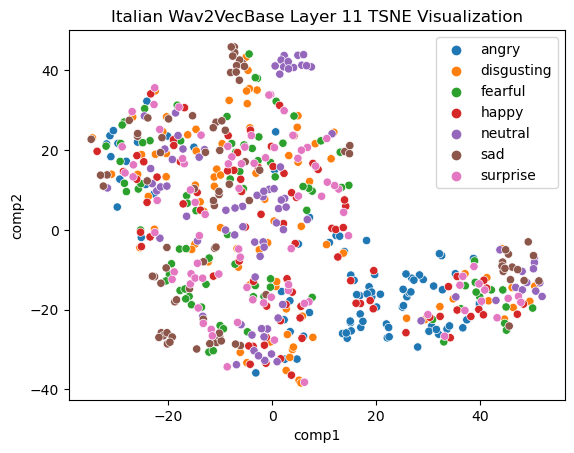

In [26]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(output, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', y='comp2', hue=data['Label'].tolist(), data=df)
plt.title(f'Italian Wav2VecBase Layer {layer} TSNE Visualization')
plt.show()

## CNN

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [29]:
model = ICASSP3CNN(768, bidirectional=True)

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

In [32]:
from tqdm import tqdm

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")

  3%|█████▌                                                                                                                                                                  | 1/30 [00:05<02:29,  5.17s/it]

epoch:1, train accu:0.1851, train loss:1.86, valid accu:0.2712, valid loss:1.86


  7%|███████████▏                                                                                                                                                            | 2/30 [00:09<02:16,  4.87s/it]

epoch:2, train accu:0.3872, train loss:1.61, valid accu:0.4153, valid loss:1.71


 10%|████████████████▊                                                                                                                                                       | 3/30 [00:14<02:08,  4.75s/it]

epoch:3, train accu:0.4872, train loss:1.33, valid accu:0.3644, valid loss:1.56


 13%|██████████████████████▍                                                                                                                                                 | 4/30 [00:19<02:03,  4.74s/it]

epoch:4, train accu:0.5660, train loss:1.11, valid accu:0.3983, valid loss:1.73


 17%|████████████████████████████                                                                                                                                            | 5/30 [00:23<01:58,  4.74s/it]

epoch:5, train accu:0.6298, train loss:1.01, valid accu:0.3898, valid loss:1.66


 20%|█████████████████████████████████▌                                                                                                                                      | 6/30 [00:28<01:53,  4.74s/it]

epoch:6, train accu:0.6191, train loss:0.92, valid accu:0.3644, valid loss:2.11


 23%|███████████████████████████████████████▏                                                                                                                                | 7/30 [00:33<01:49,  4.77s/it]

epoch:7, train accu:0.6170, train loss:0.98, valid accu:0.5000, valid loss:1.55


 27%|████████████████████████████████████████████▊                                                                                                                           | 8/30 [00:38<01:44,  4.73s/it]

epoch:8, train accu:0.7064, train loss:0.74, valid accu:0.3983, valid loss:1.90


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 9/30 [00:42<01:39,  4.74s/it]

epoch:9, train accu:0.7468, train loss:0.65, valid accu:0.4407, valid loss:1.83


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 10/30 [00:47<01:34,  4.74s/it]

epoch:10, train accu:0.7596, train loss:0.61, valid accu:0.5254, valid loss:1.27


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 11/30 [00:52<01:29,  4.72s/it]

epoch:11, train accu:0.7872, train loss:0.64, valid accu:0.4492, valid loss:1.81


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 12/30 [00:57<01:24,  4.72s/it]

epoch:12, train accu:0.7596, train loss:0.66, valid accu:0.4746, valid loss:1.61


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 13/30 [01:02<01:21,  4.81s/it]

epoch:13, train accu:0.8000, train loss:0.56, valid accu:0.5000, valid loss:1.53


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14/30 [01:06<01:16,  4.77s/it]

epoch:14, train accu:0.8064, train loss:0.50, valid accu:0.5254, valid loss:1.67


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15/30 [01:11<01:11,  4.75s/it]

epoch:15, train accu:0.8596, train loss:0.41, valid accu:0.5000, valid loss:1.42


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16/30 [01:16<01:06,  4.73s/it]

epoch:16, train accu:0.8830, train loss:0.31, valid accu:0.5763, valid loss:1.77


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17/30 [01:20<01:01,  4.70s/it]

epoch:17, train accu:0.8957, train loss:0.29, valid accu:0.5339, valid loss:1.52


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18/30 [01:25<00:56,  4.70s/it]

epoch:18, train accu:0.8723, train loss:0.34, valid accu:0.4831, valid loss:1.98


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19/30 [01:30<00:51,  4.72s/it]

epoch:19, train accu:0.9191, train loss:0.22, valid accu:0.5339, valid loss:1.60


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20/30 [01:34<00:47,  4.74s/it]

epoch:20, train accu:0.9191, train loss:0.20, valid accu:0.5847, valid loss:1.41


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21/30 [01:39<00:42,  4.70s/it]

epoch:21, train accu:0.9149, train loss:0.29, valid accu:0.5085, valid loss:1.88


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22/30 [01:44<00:37,  4.70s/it]

epoch:22, train accu:0.9362, train loss:0.17, valid accu:0.5847, valid loss:1.44


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23/30 [01:48<00:32,  4.65s/it]

epoch:23, train accu:0.9723, train loss:0.10, valid accu:0.5085, valid loss:2.24


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24/30 [01:53<00:27,  4.64s/it]

epoch:24, train accu:0.9638, train loss:0.11, valid accu:0.5678, valid loss:1.54


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25/30 [01:58<00:23,  4.68s/it]

epoch:25, train accu:0.9830, train loss:0.06, valid accu:0.5678, valid loss:2.01


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26/30 [02:02<00:18,  4.70s/it]

epoch:26, train accu:0.9936, train loss:0.05, valid accu:0.5254, valid loss:2.02


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27/30 [02:07<00:14,  4.73s/it]

epoch:27, train accu:0.9915, train loss:0.04, valid accu:0.5678, valid loss:1.79


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28/30 [02:12<00:09,  4.73s/it]

epoch:28, train accu:0.9872, train loss:0.04, valid accu:0.5424, valid loss:1.87


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29/30 [02:17<00:04,  4.70s/it]

epoch:29, train accu:0.9936, train loss:0.02, valid accu:0.6356, valid loss:1.70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.73s/it]

epoch:30, train accu:0.9979, train loss:0.01, valid accu:0.5339, valid loss:1.98


In [33]:
model_path = f'./models/wav2vecbase_{layer}.pth'

torch.save({'epoch':epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path)

In [34]:
import pandas as pd

metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 'valid loss':valid_losses, 'train accu':train_accuracies, 'valid_accu':valid_accuracies})
metadata.to_csv(f'./results/wav2vecbase_{layer}.csv ', index=False)

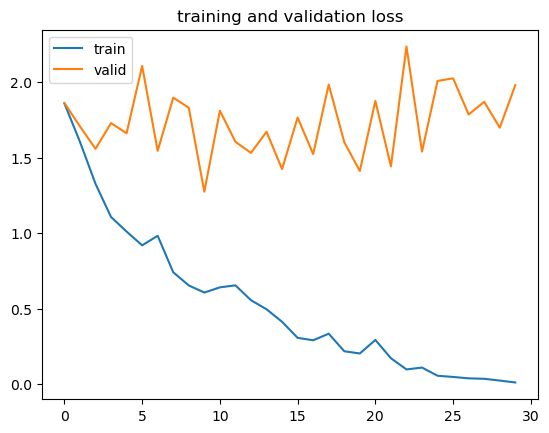

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

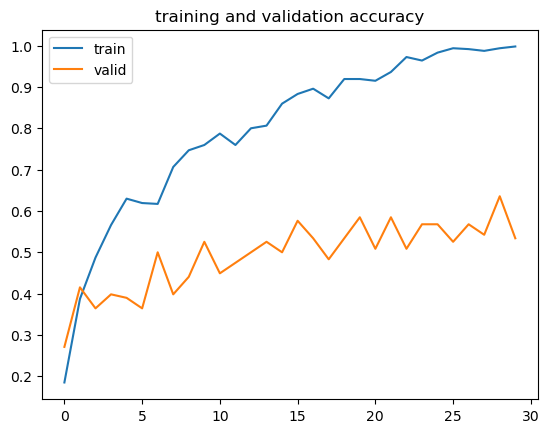

In [36]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

for inputs, lengths, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs, lengths) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

Text(0.5, 1.0, 'Italian Wav2VecBase Layer 11 Confusion Matrix')

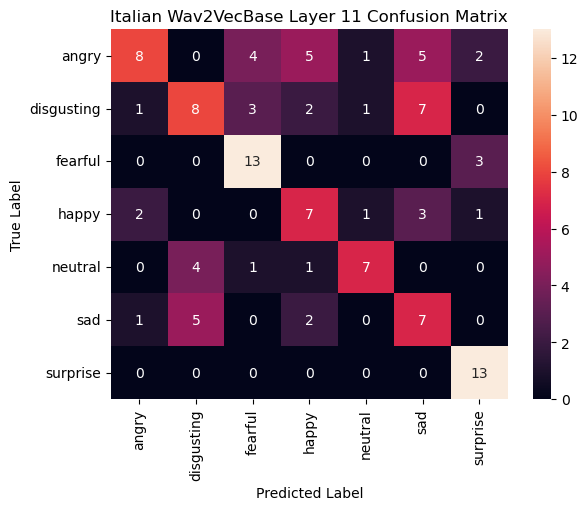

In [39]:
import numpy as np
cf = confusion_matrix(y_true, y_pred)
classes = list(data['Label'].unique())
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                     columns = [i for i in classes])
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Italian Wav2VecBase Layer {layer} Confusion Matrix')